In [1]:
import numpy as np
import pandas as pd
from astropy.cosmology import Planck13 as cosmo
from astropy.io import fits
import fsps
from matplotlib.gridspec import GridSpec
from spec_tools import Source_present, Scale_model, Oldest_galaxy, Sig_int,Likelihood_contours, Median_w_Error_cont
from spec_exam import Gen_spec
from sim_engine import *
from spec_stats import Highest_density_region
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from C_full_fit import Gen_spec2, Chi_Squared
from C_sim_test import Gen_sim, F_lam_per_M
from prospect.models.transforms import logsfr_ratios_to_masses

import dynesty
from dynesty import plotting as dyplot
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [51]:
def Get_posterior(sample,logwt,logz):
    weight = np.exp(logwt - logz[-1])

    q = [0.5 - 0.5 * 0.999999426697, 0.5 + 0.5 * 0.999999426697]
    span = _quantile(sample.T, q, weights=weight)

    s = 0.02

    bins = int(round(10. / 0.02))
    n, b = np.histogram(sample, bins=bins, weights=weight,
                        range=np.sort(span))
    n = norm_kde(n, 10.)
    x0 = 0.5 * (b[1:] + b[:-1])
    y0 = n
    
    return x0, y0 / np.trapz(y0,x0)

In [55]:
specz = 1.25
lages = [0,9.0,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9]

tuniv = Oldest_galaxy(specz)
nbins = len(lages) - 1

tbinmax = (tuniv * 0.85) * 1e9
lim1, lim2 = 7.4772, 8.0
agelims = [0,lim1] + np.linspace(lim2,np.log10(tbinmax),nbins-2).tolist() + [np.log10(tuniv*1e9)]
agebins = np.array([agelims[:-1], agelims[1:]]).T

LBT = (10**agebins.T[1][::-1][0] - 10**agebins.T[0][::-1])*1E-9

In [57]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 3, sfh = 3, dust_type = 1)
sp.params['compute_light_ages'] = True

sp.params['dust2'] =0.2
sp.params['dust1'] =0.2

tab_sfh = np.array([0.9, 0.3, 0.025, 0.01, 0.01, 0.001, 0.00001, 0.0002, 0.002, 0.0001])
tab_Z = np.array([0.2, 1.0, 1.1, 1.0, 0.95, 0.9, 1.1, 1.0, 0.9, 0.8])*0.019


sp.set_tabular_sfh(LBT,tab_sfh,Z = tab_Z )

lwa_td = sp.get_mags(tage = 4.25, bands=['sdss_g'])

sp.params['compute_light_ages'] = False


# Compare bounding method for tab to delay

In [77]:
## logL
multi_list = [fn for fn in glob('../data/out_dict/*tab_to_delay*multi**') if 'lwa' not in os.path.basename(fn)]
balls_list = [fn for fn in glob('../data/out_dict/*tab_to_delay*balls**') if 'lwa' not in os.path.basename(fn)]
single_list = [fn for fn in glob('../data/out_dict/*tab_to_delay*single**') if 'lwa' not in os.path.basename(fn)]
cubes_list = [fn for fn in glob('../data/out_dict/*tab_to_delay*cubes**') if 'lwa' not in os.path.basename(fn)]

mL = []
bL = []
sL = []
cL = []

for i in range(len(multi_list)):
    dres = np.load(multi_list[i]).item()
    mL.append(dres.logl[-1])

for i in range(len(balls_list)):
    dres = np.load(balls_list[i]).item()
    bL.append(dres.logl[-1])

for i in range(len(single_list)):
    dres = np.load(single_list[i]).item()
    sL.append(dres.logl[-1])
    
for i in range(len(cubes_list)):
    dres = np.load(cubes_list[i]).item()
    cL.append(dres.logl[-1])

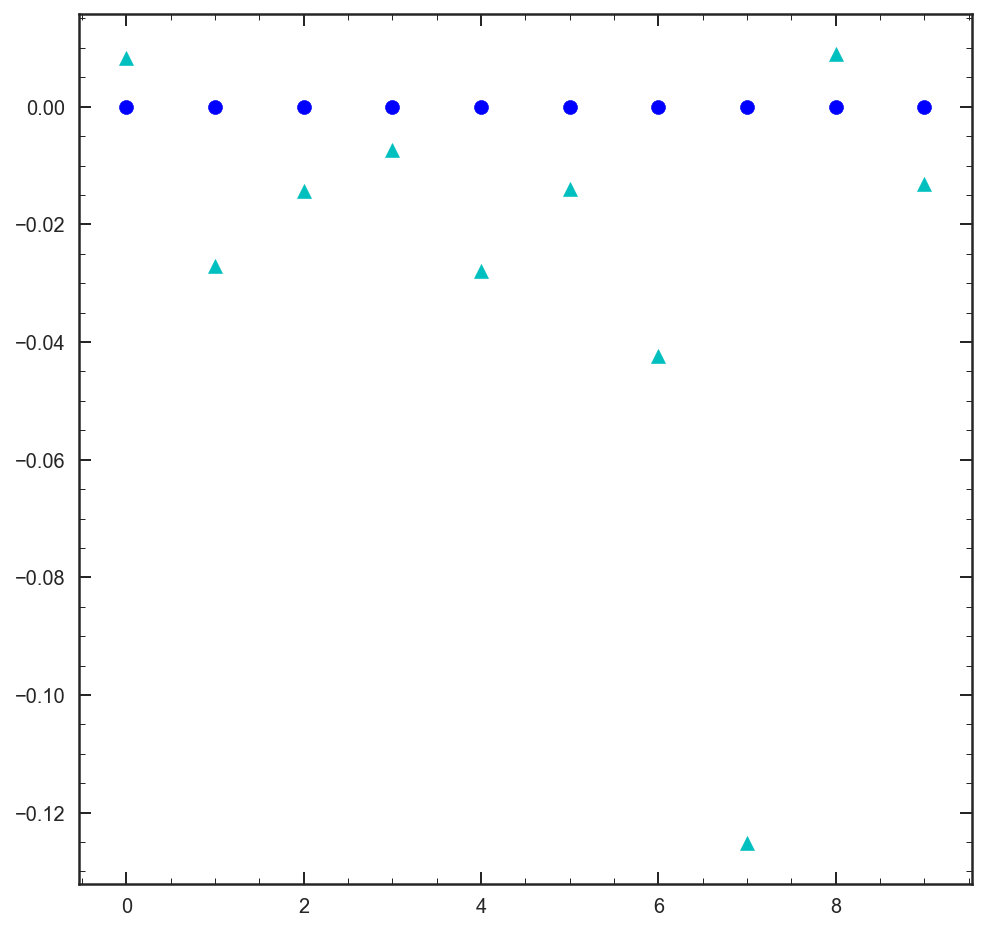

In [86]:
plt.figure(figsize=[8,8])
plt.scatter(range(len(mL)),np.abs(mL) - np.abs(mL),color='b', marker = 'o')
# plt.scatter(range(len(bL)),np.abs(bL) - np.abs(mL),color='r', marker = 'p')
plt.scatter(range(len(sL)),np.abs(sL) - np.abs(mL),color='c', marker = '^')
# plt.scatter(range(len(cL)),np.abs(cL) - np.abs(mL),color='k', marker = '*')

# plt.plot([-155,-120],[-155,-120])

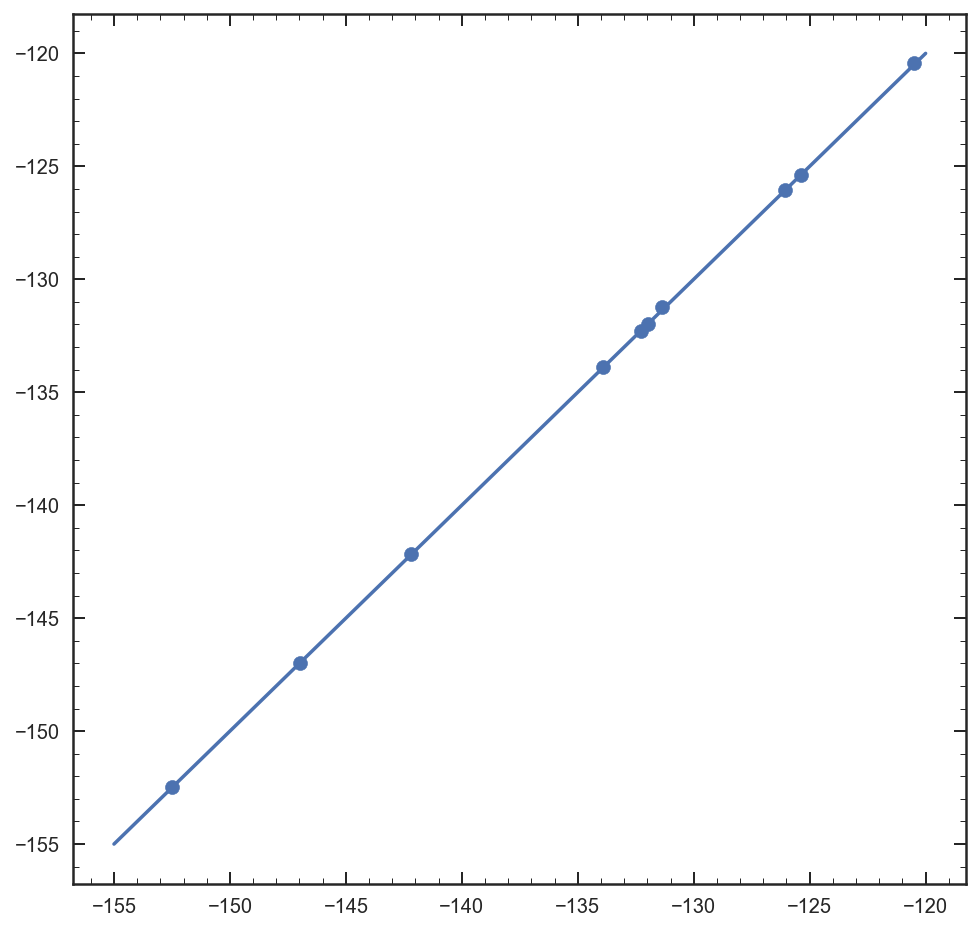

In [89]:
plt.figure(figsize=[8,8])
plt.scatter(mL,sL)
plt.plot([-155,-120],[-155,-120])

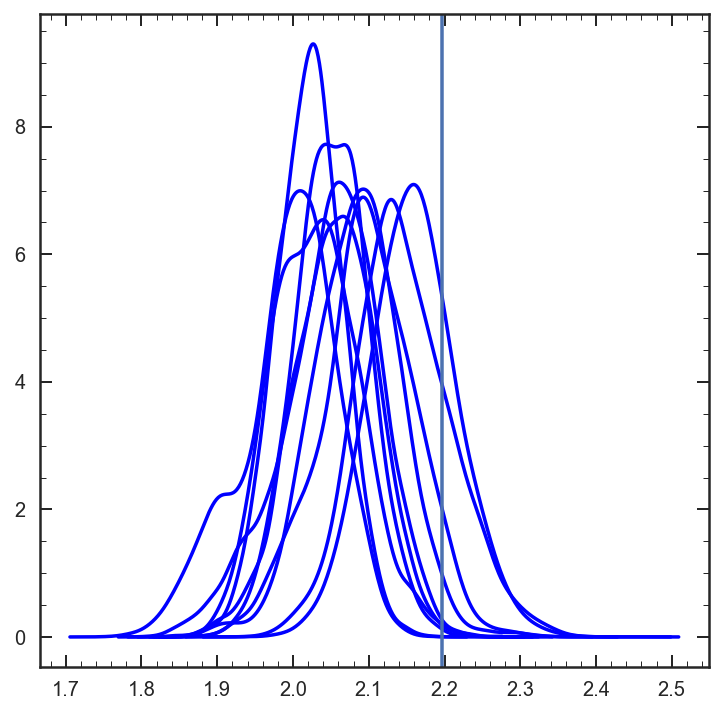

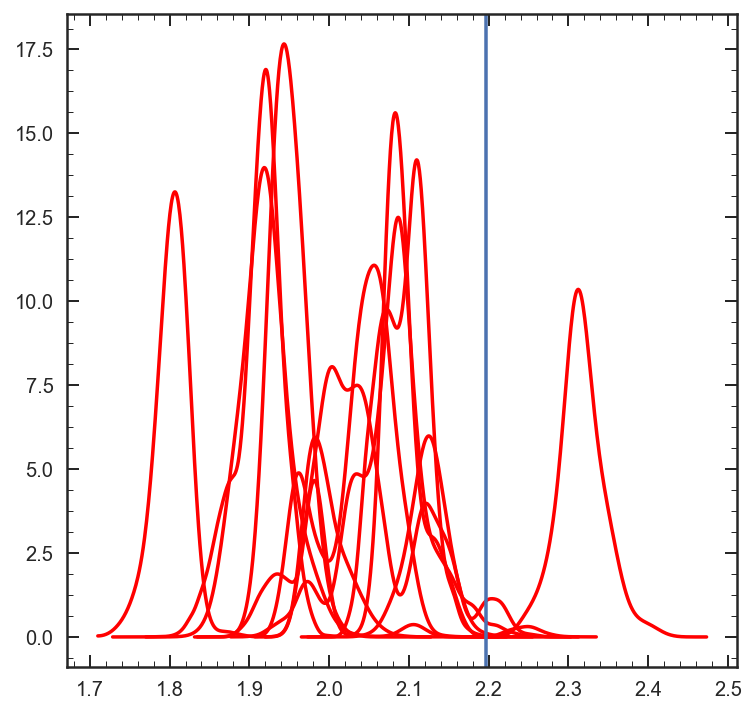

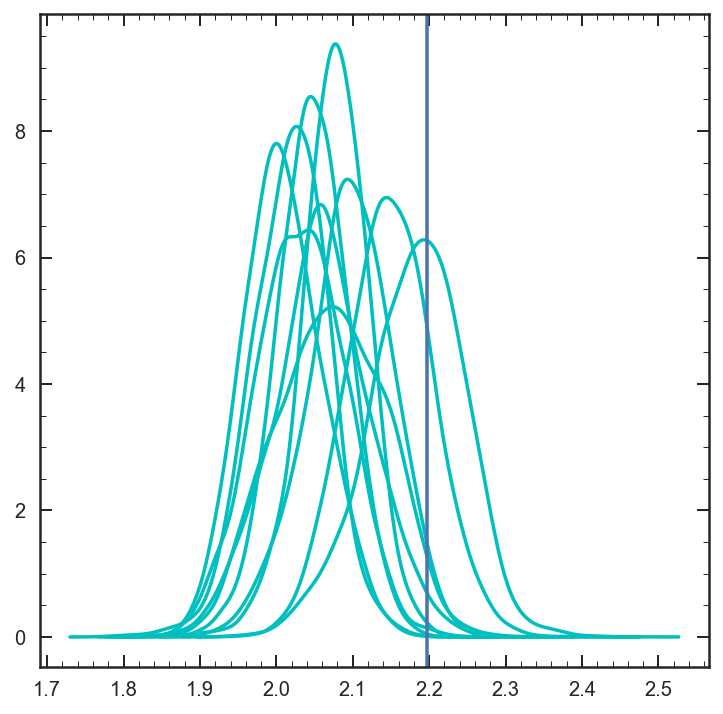

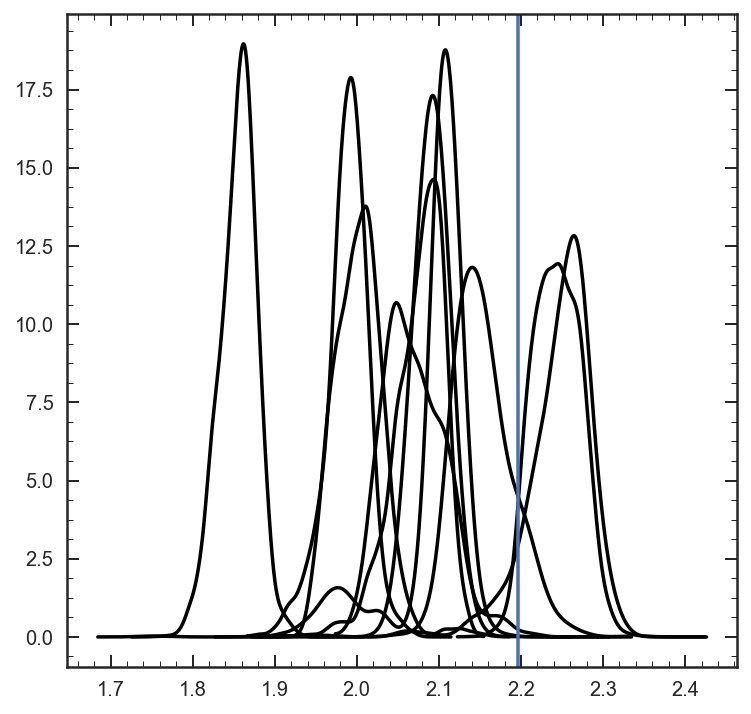

In [141]:
plt.figure(figsize=[6,6])
for i in range(10):
    mlwa = np.load('../data/out_dict/sim_test_tab_to_delay_multi_{0}_lwa.npy'.format(i+1))
    
    dres = np.load('../data/out_dict/sim_test_tab_to_delay_multi_{0}.npy'.format(i+1)).item()
    dres.samples[:,1] = mlwa
    m,Pm = Get_posterior(dres.samples[:,1], dres.logwt, dres.logz)
    
    plt.plot(m,Pm,'b')
plt.axvline(lwa_td)
    
plt.figure(figsize=[6,6])    
for i in range(10):
    blwa = np.load('../data/out_dict/sim_test_tab_to_delay_balls_{0}_lwa.npy'.format(i+1)) 
    
    dres = np.load('../data/out_dict/sim_test_tab_to_delay_balls_{0}.npy'.format(i+1)).item()
    dres.samples[:,1] = blwa
    b,Pb = Get_posterior(dres.samples[:,1], dres.logwt, dres.logz)
    
    plt.plot(b,Pb,'r')

plt.axvline(lwa_td)

plt.figure(figsize=[6,6])
for i in range(10):
    slwa = np.load('../data/out_dict/sim_test_tab_to_delay_single_{0}_lwa.npy'.format(i+1)) 
    
    dres = np.load('../data/out_dict/sim_test_tab_to_delay_single_{0}.npy'.format(i+1)).item()
    dres.samples[:,1] = slwa
    s,Ps = Get_posterior(dres.samples[:,1], dres.logwt, dres.logz)

    plt.plot(s,Ps,'c')
plt.axvline(lwa_td)

plt.figure(figsize=[6,6])
for i in range(10):
    clwa = np.load('../data/out_dict/sim_test_tab_to_delay_cubes_{0}_lwa.npy'.format(i+1)) 
    
    dres = np.load('../data/out_dict/sim_test_tab_to_delay_cubes_{0}.npy'.format(i+1)).item()
    dres.samples[:,1] = clwa
    c,Pc = Get_posterior(dres.samples[:,1], dres.logwt, dres.logz)
    
    plt.plot(c,Pc,'k')
plt.axvline(lwa_td)

# Compare bounding method for delay to tab

In [133]:
## logL

mL = []
bL = []
sL = []
cL = []

for i in np.arange(1,11,1):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_multi_{0}.npy'.format(i)).item()
    mL.append(dres.logl[-1])

    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_balls_{0}.npy'.format(i)).item()
    bL.append(dres.logl[-1])

    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_single_{0}.npy'.format(i)).item()
    sL.append(dres.logl[-1])
    
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_cubes_{0}.npy'.format(i)).item()
    cL.append(dres.logl[-1])
    

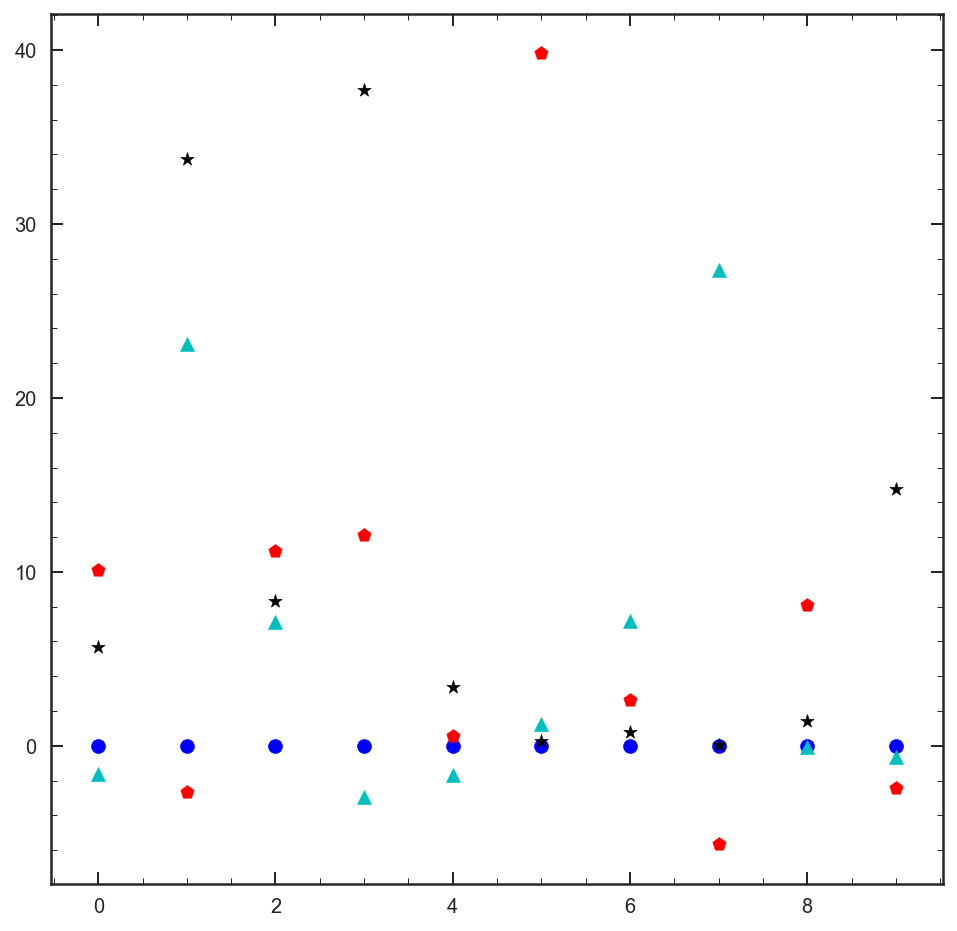

In [135]:
plt.figure(figsize=[8,8])
plt.scatter(range(len(mL)),np.abs(mL) - np.abs(mL),color='b', marker = 'o')
plt.scatter(range(len(bL)),np.abs(bL) - np.abs(mL),color='r', marker = 'p')
plt.scatter(range(len(sL)),np.abs(sL) - np.abs(mL),color='c', marker = '^')
plt.scatter(range(len(cL)),np.abs(cL) - np.abs(mL),color='k', marker = '*')

# plt.plot([-155,-120],[-155,-120])

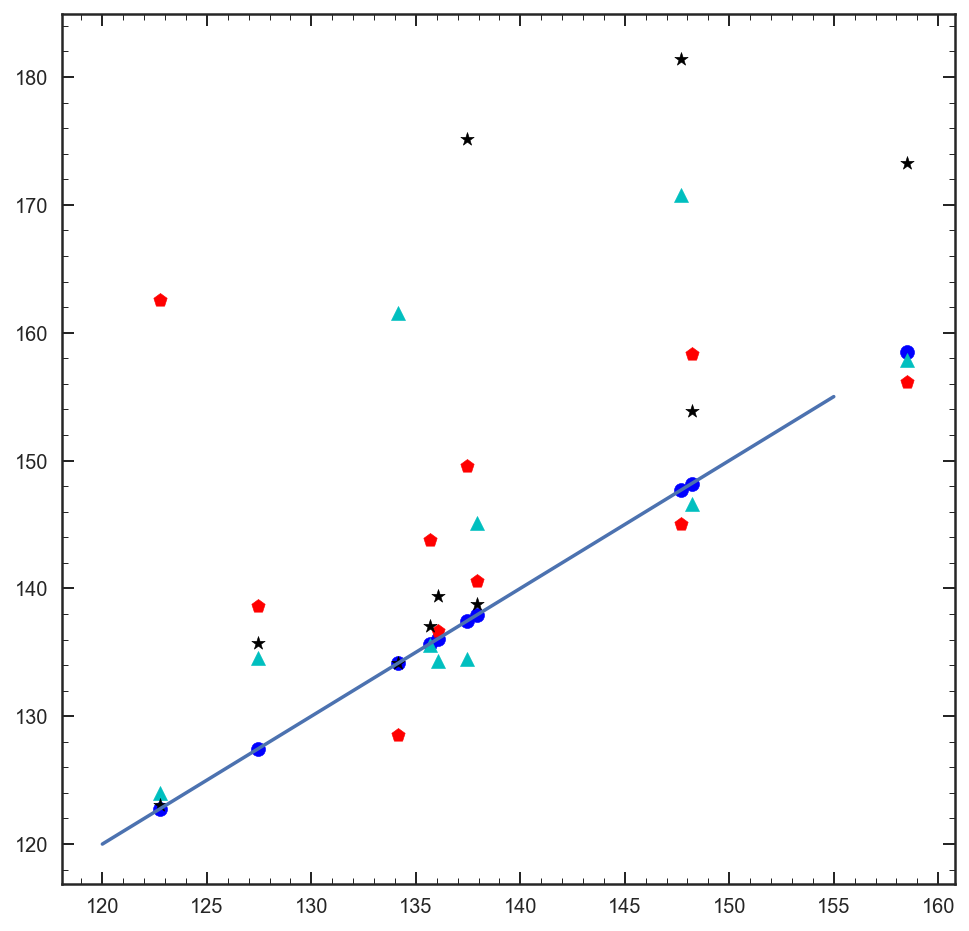

In [136]:
plt.figure(figsize=[8,8])
plt.scatter(np.abs(mL),np.abs(mL),color='b', marker = 'o')
plt.scatter(np.abs(mL),np.abs(bL),color='r', marker = 'p')
plt.scatter(np.abs(mL),np.abs(sL),color='c', marker = '^')
plt.scatter(np.abs(mL),np.abs(cL),color='k', marker = '*')

plt.plot([155,120],[155,120])

In [63]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 4, tau=0.1, dust_type = 1)
sp.params['compute_light_ages'] = True

sp.params['dust2'] =0.2
sp.params['dust1'] =0.2
sp.params['tau'] =0.3
sp.params['logzsol'] = np.log10(0.8)

lwa_dt = sp.get_mags(tage = 4.5, bands =['sdss_g'])
       
sp.params['compute_light_ages'] = False

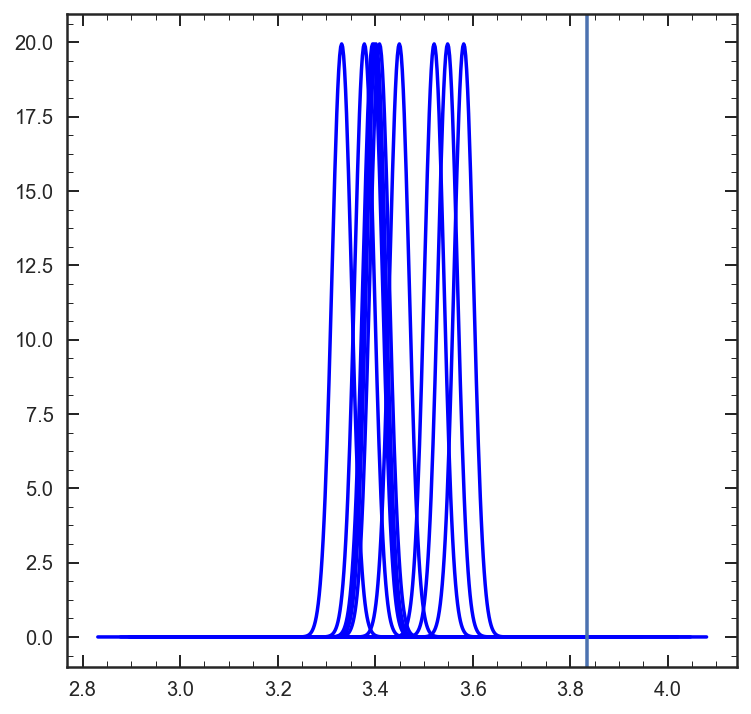

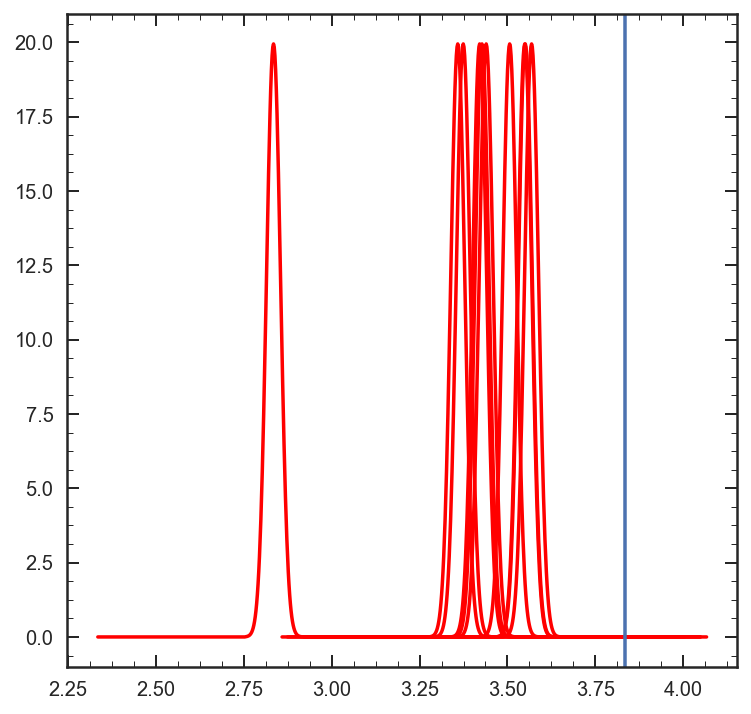

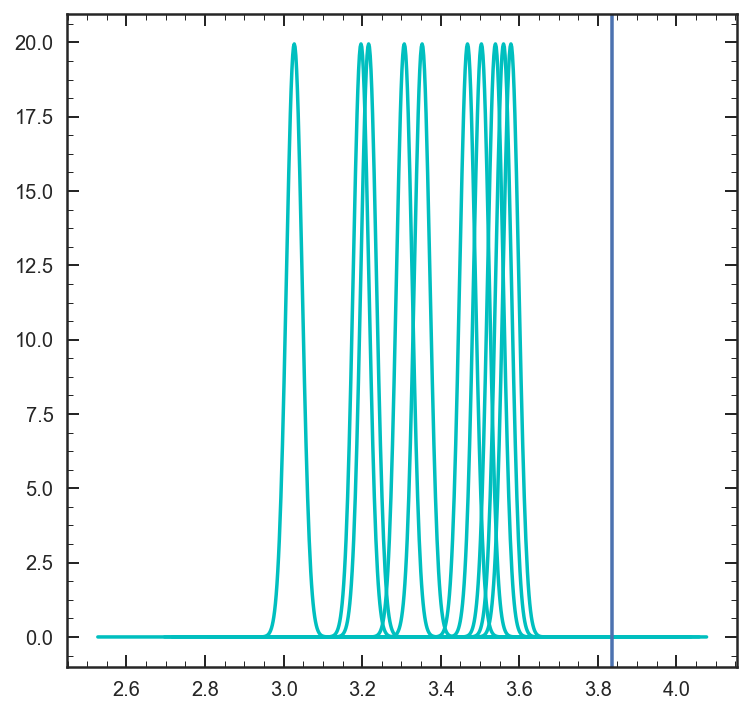

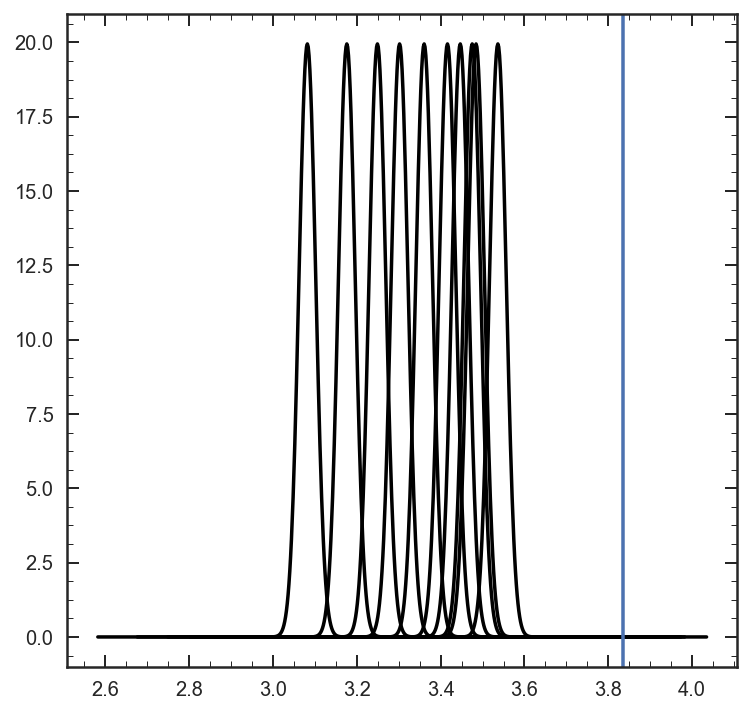

In [142]:
plt.figure(figsize=[6,6])
for i in range(10):
    mlwa = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_multi_{0}_lwa.npy'.format(i+1))
    
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_multi_{0}.npy'.format(i+1)).item()
    dres.samples[:,1] = mlwa
    m,Pm = Get_posterior(dres.samples[:,1], dres.logwt, dres.logz)
    
    plt.plot(m,Pm,'b')
plt.axvline(lwa_dt)
    
plt.figure(figsize=[6,6])    
for i in range(10):
    blwa = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_balls_{0}_lwa.npy'.format(i+1)) 
    
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_balls_{0}.npy'.format(i+1)).item()
    dres.samples[:,1] = blwa
    b,Pb = Get_posterior(dres.samples[:,1], dres.logwt, dres.logz)
    
    plt.plot(b,Pb,'r')

plt.axvline(lwa_dt)

plt.figure(figsize=[6,6])
for i in range(10):
    slwa = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_single_{0}_lwa.npy'.format(i+1)) 
    
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_single_{0}.npy'.format(i+1)).item()
    dres.samples[:,1] = slwa
    s,Ps = Get_posterior(dres.samples[:,1], dres.logwt, dres.logz)

    plt.plot(s,Ps,'c')
plt.axvline(lwa_dt)

plt.figure(figsize=[6,6])
for i in range(10):
    clwa = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_cubes_{0}_lwa.npy'.format(i+1)) 
    
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_cubes_{0}.npy'.format(i+1)).item()
    dres.samples[:,1] = clwa
    c,Pc = Get_posterior(dres.samples[:,1], dres.logwt, dres.logz)
    
    plt.plot(c,Pc,'k')
plt.axvline(lwa_dt)

# Compare td spec_fits

In [110]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 3, sfh = 3, dust_type = 1)
sp.params['dust2'] =0.2
sp.params['dust1'] =0.2

tab_sfh = np.array([0.9, 0.3, 0.025, 0.01, 0.01, 0.001, 0.00001, 0.0002, 0.002, 0.0001])
tab_Z = np.array([0.2, 1.0, 1.1, 1.0, 0.95, 0.9, 1.1, 1.0, 0.9, 0.8])*0.019

sp.set_tabular_sfh(LBT,tab_sfh, Z = tab_Z )

wave1, flux1 = sp.get_spectrum(tage = 4.25, peraa = True)

mass_perc1 = sp.stellar_mass
 
D_l = cosmo.luminosity_distance(specz).value # in Mpc
conv = 3.086E24
lsol_to_fsol = 3.839E33

mass_transform = (10**11 / mass_perc1) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)

In [126]:
# multi_list = [fn for fn in glob('../data/out_dict/*tab_to_delay*multi**') if 'lwa' not in os.path.basename(fn)]
# balls_list = [fn for fn in glob('../data/out_dict/*tab_to_delay*balls**') if 'lwa' not in os.path.basename(fn)]
# single_list = [fn for fn in glob('../data/out_dict/*tab_to_delay*single**') if 'lwa' not in os.path.basename(fn)]
# cubes_list = [fn for fn in glob('../data/out_dict/*tab_to_delay*cubes**') if 'lwa' not in os.path.basename(fn)]

# sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 4, tau=0.1, dust_type = 1)

# # mL = []
# # bL = []
# # sL = []
# # cL = []

# for i in range(len(multi_list)):
#     dres = np.load(multi_list[i]).item()
#     bfZ, bft, bftau, bfz, bfd, bflm = dres.samples[-1]

#     sp.params['dust2'] = bfd
#     sp.params['dust1'] = bfd
#     sp.params['tau'] = bftau
#     sp.params['logzsol'] = np.log10(bfZ)
#     wave, flux = sp.get_spectrum(tage = bft, peraa = True)

#     D_l = cosmo.luminosity_distance(bfz).value # in Mpc
#     MT = (10**bflm * lsol_to_fsol) / (4 * np.pi * (D_l*conv)**2)

#     plt.figure(figsize=[15,5])
#     plt.plot(np.log10(wave1), flux1 * mass_transform,'k')
#     plt.plot(np.log10(wave), flux * MT,'b')
#     plt.title(dres.logl[-1])
#     plt.xlim(2.8,5)

# for i in range(len(balls_list)):
#     dres = np.load(balls_list[i]).item()
#     bfZ, bft, bftau, bfz, bfd, bflm = dres.samples[-1]

#     sp.params['dust2'] = bfd
#     sp.params['dust1'] = bfd
#     sp.params['tau'] = bftau
#     sp.params['logzsol'] = np.log10(bfZ)
#     wave, flux = sp.get_spectrum(tage = bft, peraa = True)

#     D_l = cosmo.luminosity_distance(bfz).value # in Mpc
#     MT = (10**bflm * lsol_to_fsol) / (4 * np.pi * (D_l*conv)**2)

#     plt.figure(figsize=[15,5])
#     plt.plot(np.log10(wave1), flux1 * mass_transform,'k')
#     plt.plot(np.log10(wave), flux * MT,'r')
#     plt.title(dres.logl[-1])
#     plt.xlim(2.8,5)
    
# for i in range(len(single_list)):
#     dres = np.load(single_list[i]).item()
#     bfZ, bft, bftau, bfz, bfd, bflm = dres.samples[-1]

#     sp.params['dust2'] = bfd
#     sp.params['dust1'] = bfd
#     sp.params['tau'] = bftau
#     sp.params['logzsol'] = np.log10(bfZ)
#     wave, flux = sp.get_spectrum(tage = bft, peraa = True)

#     D_l = cosmo.luminosity_distance(bfz).value # in Mpc
#     MT = (10**bflm * lsol_to_fsol) / (4 * np.pi * (D_l*conv)**2)

#     plt.figure(figsize=[15,5])
#     plt.plot(np.log10(wave1), flux1 * mass_transform,'k')
#     plt.plot(np.log10(wave), flux * MT,'c')
#     plt.title(dres.logl[-1])
#     plt.xlim(2.8,5)
    
# for i in range(len(cubes_list)):
#     dres = np.load(cubes_list[i]).item()
#     bfZ, bft, bftau, bfz, bfd, bflm = dres.samples[-1]

#     sp.params['dust2'] = bfd
#     sp.params['dust1'] = bfd
#     sp.params['tau'] = bftau
#     sp.params['logzsol'] = np.log10(bfZ)
#     wave, flux = sp.get_spectrum(tage = bft, peraa = True)

#     D_l = cosmo.luminosity_distance(bfz).value # in Mpc
#     MT = (10**bflm * lsol_to_fsol) / (4 * np.pi * (D_l*conv)**2)

#     plt.figure(figsize=[15,5])
#     plt.plot(np.log10(wave1), flux1 * mass_transform,'k')
#     plt.plot(np.log10(wave), flux * MT,'g')
#     plt.title(dres.logl[-1])
#     plt.xlim(2.8,5)

# Compare td spec_fits

In [137]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 4, tau=0.1, dust_type = 1)
sp.params['dust2'] =0.2
sp.params['dust1'] =0.2
sp.params['tau'] =0.3
sp.params['logzsol'] = np.log10(0.8)

wave2, flux2 = sp.get_spectrum(tage = 4.25, peraa = True)

mass_perc2 = sp.stellar_mass

D_l = cosmo.luminosity_distance(specz).value # in Mpc
conv = 3.086E24
lsol_to_fsol = 3.839E33

mass_transform = 10**11* lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)

In [140]:
# multi_list = [fn for fn in glob('../data/out_dict/*delay_to*multi**') if 'lwa' not in os.path.basename(fn)]
# balls_list = [fn for fn in glob('../data/out_dict/*delay_to*balls**') if 'lwa' not in os.path.basename(fn)]
# single_list = [fn for fn in glob('../data/out_dict/*delay_to*single**') if 'lwa' not in os.path.basename(fn)]
# cubes_list = [fn for fn in glob('../data/out_dict/*delay_to*cubes**') if 'lwa' not in os.path.basename(fn)]

# sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 3, dust_type = 1)

# for i in range(len(multi_list)):
#     dres = np.load(multi_list[i]).item()
#     bfZ, bft, bft1, bft2, bft3, bft4, bft5, bft6, bft7, bft8, bft9, bft10, bfz, bfd, bflm = dres.samples[-1]

#     sp.params['dust2'] = bfd
#     sp.params['dust1'] = bfd
#     sp.params['logzsol'] = np.log10(bfZ)
#     sp.set_tabular_sfh(LBT,np.array([bft1, bft2, bft3, bft4, bft5, bft6, bft7, bft8, bft9, bft10]))

#     wave, flux = sp.get_spectrum(tage = bft, peraa = True)

#     mp1 = sp.stellar_mass
 
#     D_l = cosmo.luminosity_distance(bfz).value # in Mpc
#     MT = (10**bflm / mp1) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)

#     plt.figure(figsize=[15,5])
#     plt.plot(np.log10(wave2), flux2 * mass_transform,'k')
#     plt.plot(np.log10(wave), flux * MT,'b')
#     plt.title(dres.logl[-1])
#     plt.xlim(2.8,5)

# for i in range(len(balls_list)):
#     dres = np.load(balls_list[i]).item()
#     bfZ, bft, bft1, bft2, bft3, bft4, bft5, bft6, bft7, bft8, bft9, bft10, bfz, bfd, bflm = dres.samples[-1]

#     sp.params['dust2'] = bfd
#     sp.params['dust1'] = bfd
#     sp.params['logzsol'] = np.log10(bfZ)
#     sp.set_tabular_sfh(LBT,np.array([bft1, bft2, bft3, bft4, bft5, bft6, bft7, bft8, bft9, bft10]))

#     wave, flux = sp.get_spectrum(tage = bft, peraa = True)

#     mp1 = sp.stellar_mass
 
#     D_l = cosmo.luminosity_distance(bfz).value # in Mpc
#     MT = (10**bflm / mp1) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)

#     plt.figure(figsize=[15,5])
#     plt.plot(np.log10(wave2), flux2 * mass_transform,'k')
#     plt.plot(np.log10(wave), flux * MT,'r')
#     plt.title(dres.logl[-1])
#     plt.xlim(2.8,5)
    
# for i in range(len(single_list)):
#     dres = np.load(single_list[i]).item()
#     bfZ, bft, bft1, bft2, bft3, bft4, bft5, bft6, bft7, bft8, bft9, bft10, bfz, bfd, bflm = dres.samples[-1]

#     sp.params['dust2'] = bfd
#     sp.params['dust1'] = bfd
#     sp.params['logzsol'] = np.log10(bfZ)
#     sp.set_tabular_sfh(LBT,np.array([bft1, bft2, bft3, bft4, bft5, bft6, bft7, bft8, bft9, bft10]))

#     wave, flux = sp.get_spectrum(tage = bft, peraa = True)

#     mp1 = sp.stellar_mass
 
#     D_l = cosmo.luminosity_distance(bfz).value # in Mpc
#     MT = (10**bflm / mp1) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)

#     plt.figure(figsize=[15,5])
#     plt.plot(np.log10(wave2), flux2 * mass_transform,'k')
#     plt.plot(np.log10(wave), flux * MT,'c')
#     plt.title(dres.logl[-1])
#     plt.xlim(2.8,5)
    
# for i in range(len(cubes_list)):
#     dres = np.load(cubes_list[i]).item()
#     bfZ, bft, bft1, bft2, bft3, bft4, bft5, bft6, bft7, bft8, bft9, bft10, bfz, bfd, bflm = dres.samples[-1]

#     sp.params['dust2'] = bfd
#     sp.params['dust1'] = bfd
#     sp.params['logzsol'] = np.log10(bfZ)
#     sp.set_tabular_sfh(LBT,np.array([bft1, bft2, bft3, bft4, bft5, bft6, bft7, bft8, bft9, bft10]))

#     wave, flux = sp.get_spectrum(tage = bft, peraa = True)

#     mp1 = sp.stellar_mass
 
#     D_l = cosmo.luminosity_distance(bfz).value # in Mpc
#     MT = (10**bflm / mp1) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)

#     plt.figure(figsize=[15,5])
#     plt.plot(np.log10(wave2), flux2 * mass_transform,'k')
#     plt.plot(np.log10(wave), flux * MT,'g')
#     plt.title(dres.logl[-1])
#     plt.xlim(2.8,5)

# Compare td SFHs

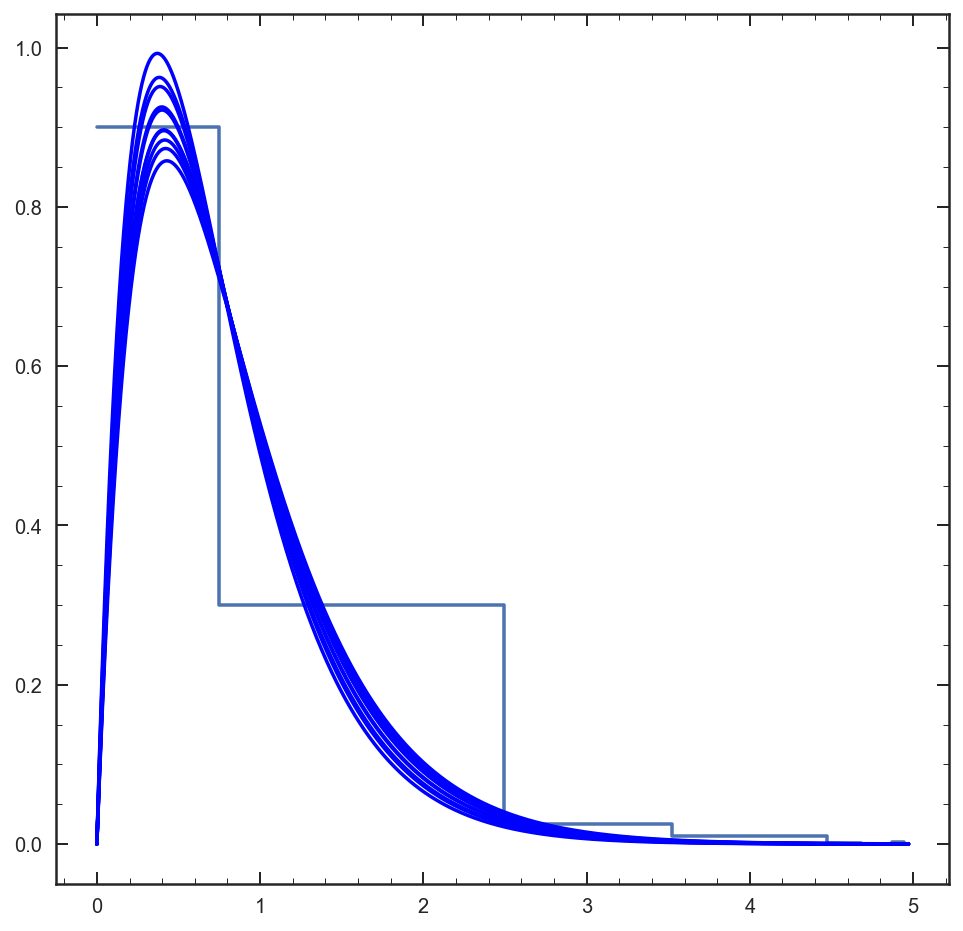

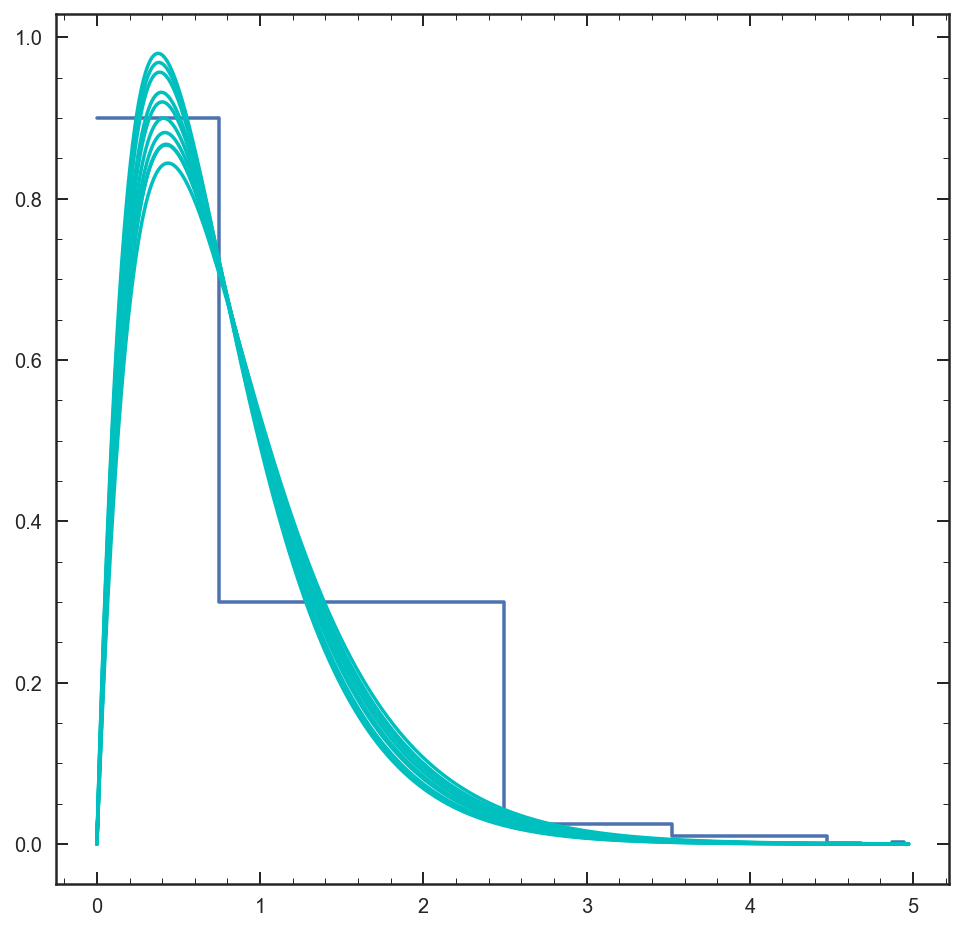

In [129]:
multi_list = [fn for fn in glob('../data/out_dict/*tab_to_delay*multi**') if 'lwa' not in os.path.basename(fn)]
balls_list = [fn for fn in glob('../data/out_dict/*tab_to_delay*balls**') if 'lwa' not in os.path.basename(fn)]
single_list = [fn for fn in glob('../data/out_dict/*tab_to_delay*single**') if 'lwa' not in os.path.basename(fn)]
cubes_list = [fn for fn in glob('../data/out_dict/*tab_to_delay*cubes**') if 'lwa' not in os.path.basename(fn)]

tab_sfh = np.array([0.9, 0.3, 0.025, 0.01, 0.01, 0.001, 0.00001, 0.0002, 0.002, 0.0001])

T= np.arange(0,Oldest_galaxy(1.25)+.001,.001)

plt.figure(figsize=[8,8])
plt.step(np.append(0,LBT), np.append(tab_sfh[0], tab_sfh))

for i in range(len(multi_list)):
    dres = np.load(multi_list[i]).item()
    t,pt = Get_posterior(dres.samples[:,2], dres.logwt,dres.logz)

    tau = t[pt == max(pt)][0]
    
    sfh = T * np.exp(-T / tau)

    sfh /= np.trapz(sfh,T)
    
    plt.plot(T,sfh,'b')

    
# plt.figure(figsize=[8,8])
# plt.step(np.append(0,LBT), np.append(tab_sfh[0], tab_sfh))
    
# for i in range(len(balls_list)):
#     dres = np.load(balls_list[i]).item()
#     t,pt = Get_posterior(dres.samples[:,2], dres.logwt,dres.logz)

#     tau = t[pt == max(pt)][0]
    
#     sfh = T * np.exp(-T / tau)

#     sfh /= np.trapz(sfh,T)
    
#     plt.plot(T,sfh,'r')
  

plt.figure(figsize=[8,8])
plt.step(np.append(0,LBT), np.append(tab_sfh[0], tab_sfh))

for i in range(len(single_list)):
    dres = np.load(single_list[i]).item()
    t,pt = Get_posterior(dres.samples[:,2], dres.logwt,dres.logz)

    tau = t[pt == max(pt)][0]
    
    sfh = T * np.exp(-T / tau)

    sfh /= np.trapz(sfh,T)
    
    plt.plot(T,sfh,'c')

    
# plt.figure(figsize=[8,8])
# plt.step(np.append(0,LBT), np.append(tab_sfh[0], tab_sfh))

# for i in range(len(cubes_list)):
#     dres = np.load(cubes_list[i]).item()
#     t,pt = Get_posterior(dres.samples[:,2], dres.logwt,dres.logz)

#     tau = t[pt == max(pt)][0]
    
#     sfh = T * np.exp(-T / tau)

#     sfh /= np.trapz(sfh,T)
    
#     plt.plot(T,sfh,'k')

# Compare dt SFHs

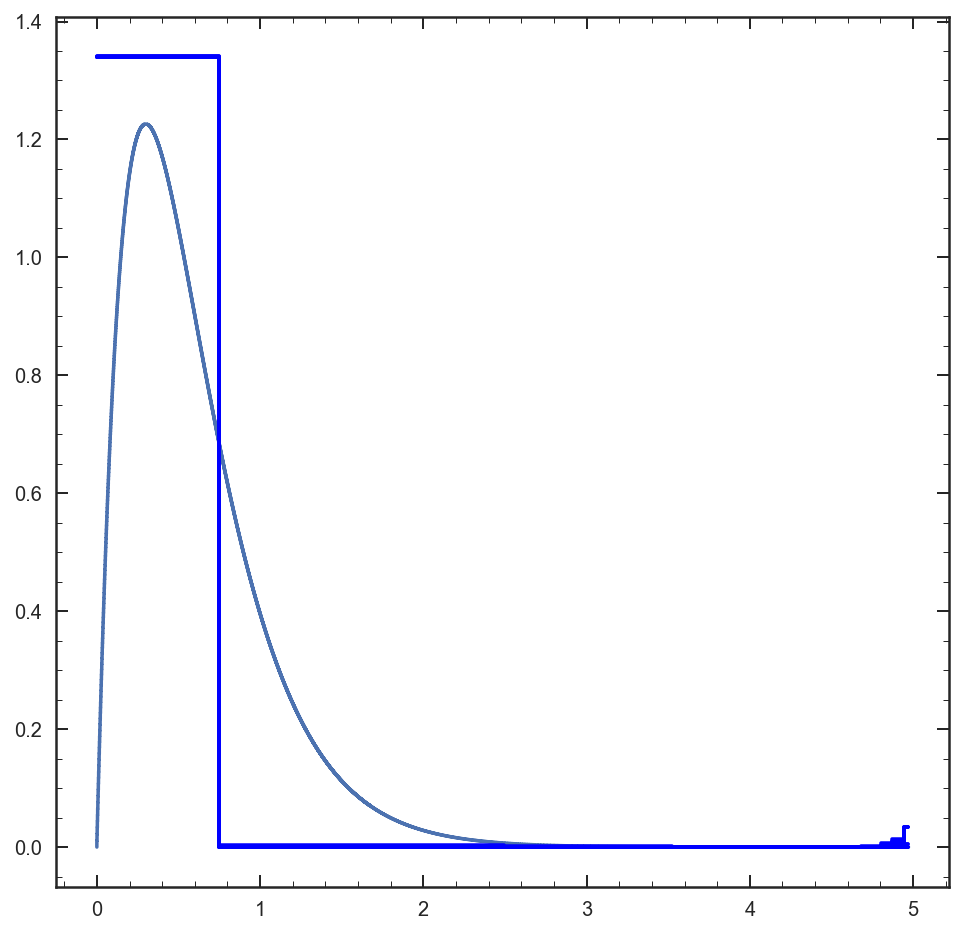

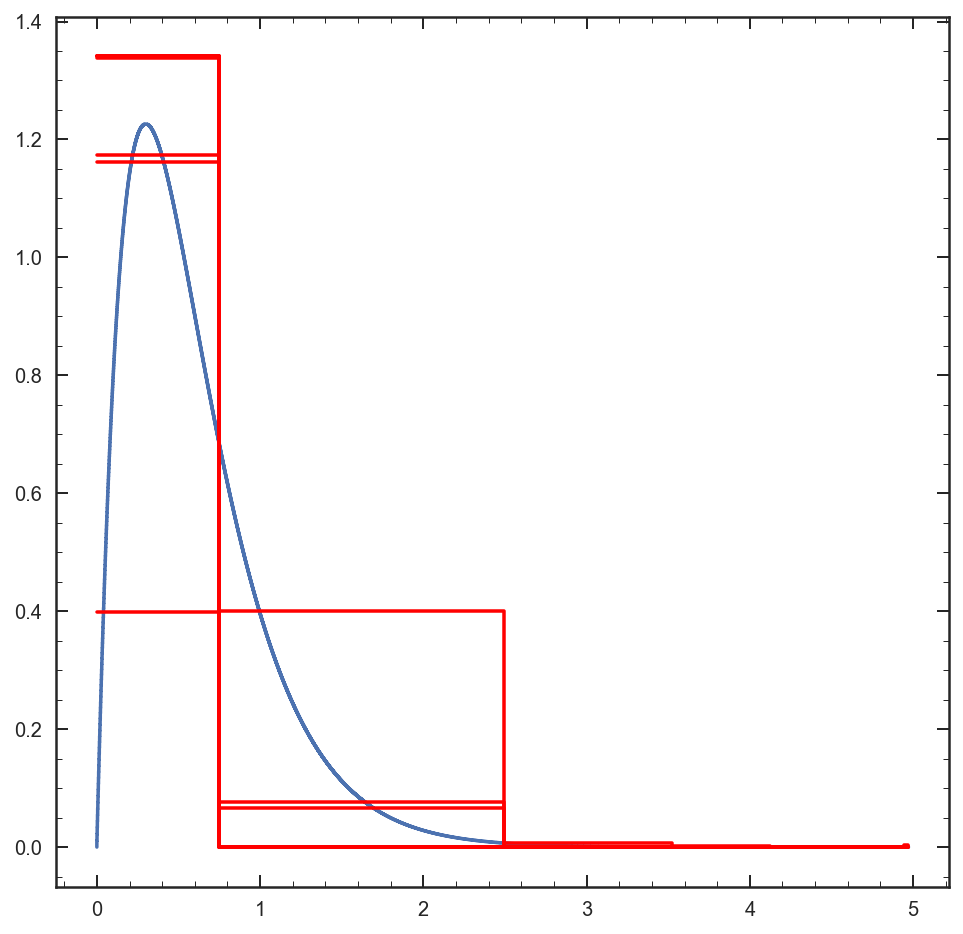

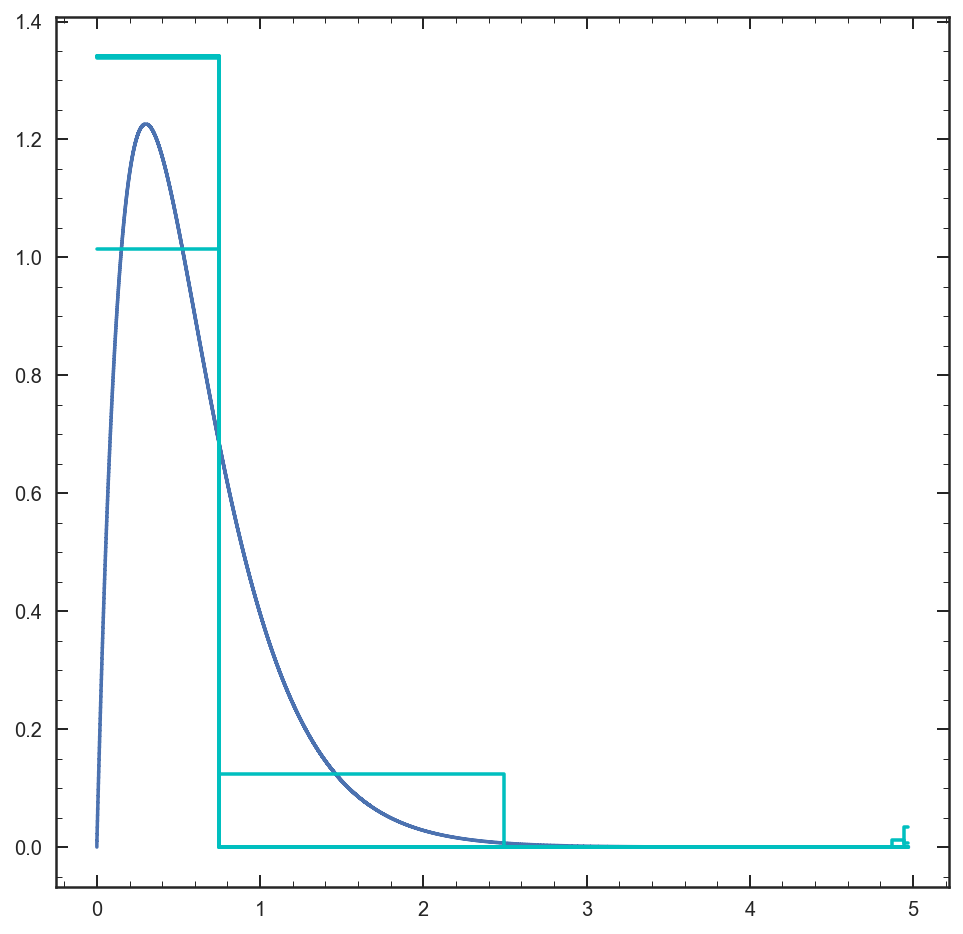

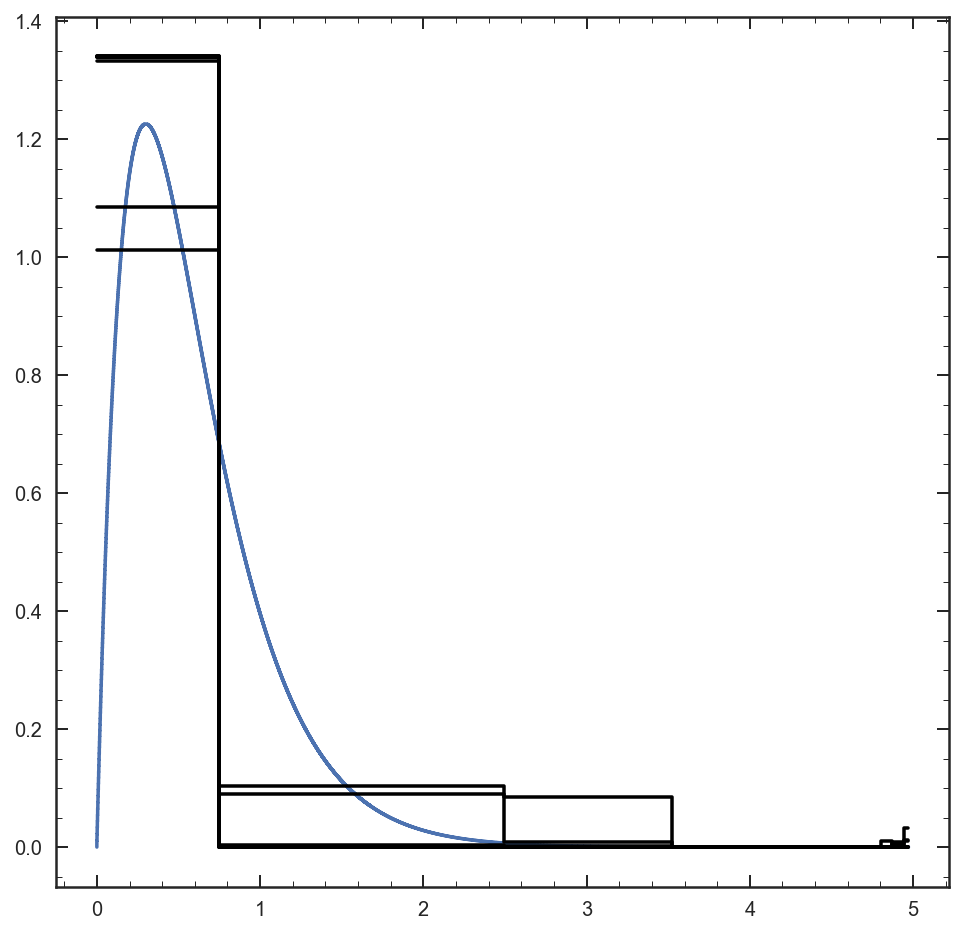

In [139]:
multi_list = [fn for fn in glob('../data/out_dict/*delay_to*multi**') if 'lwa' not in os.path.basename(fn)]
balls_list = [fn for fn in glob('../data/out_dict/*delay_to*balls**') if 'lwa' not in os.path.basename(fn)]
single_list = [fn for fn in glob('../data/out_dict/*delay_to*single**') if 'lwa' not in os.path.basename(fn)]
cubes_list = [fn for fn in glob('../data/out_dict/*delay_to*cubes**') if 'lwa' not in os.path.basename(fn)]

sfh = T * np.exp(-T / 0.3)

sfh /= np.trapz(sfh,T)

plt.figure(figsize=[8,8])
plt.step(T, sfh,)

for i in range(len(multi_list)):
    dres = np.load(multi_list[i]).item()
    md = np.zeros(10)

    for ii in range(10):
        t,pt = Get_posterior(dres.samples[:,ii + 2],dres.logwt,dres.logz)
#         md[ii], le, he = Highest_density_region(pt,t)
        md[ii] = t[pt == max(pt)]
    plt.step(np.append(0,LBT), np.append(md[0],md), 'b')

plt.figure(figsize=[8,8])
plt.step(T, sfh,)

for i in range(len(balls_list)):
    dres = np.load(balls_list[i]).item()
    md = np.zeros(10)

    for ii in range(10):
        t,pt = Get_posterior(dres.samples[:,ii + 2],dres.logwt,dres.logz)
#         md[ii], le, he = Highest_density_region(pt,t)
        md[ii] = t[pt == max(pt)]
    plt.step(np.append(0,LBT), np.append(md[0],md), 'r')
    
plt.figure(figsize=[8,8])
plt.step(T, sfh,)

for i in range(len(single_list)):
    dres = np.load(single_list[i]).item()
    md = np.zeros(10)

    for ii in range(10):
        t,pt = Get_posterior(dres.samples[:,ii + 2],dres.logwt,dres.logz)
#         md[ii], le, he = Highest_density_region(pt,t)
        md[ii] = t[pt == max(pt)]
    plt.step(np.append(0,LBT), np.append(md[0],md), 'c')
    
plt.figure(figsize=[8,8])
plt.step(T, sfh,)

for i in range(len(cubes_list)):
    dres = np.load(cubes_list[i]).item()
    md = np.zeros(10)

    for ii in range(10):
        t,pt = Get_posterior(dres.samples[:,ii + 2],dres.logwt,dres.logz)
#         md[ii], le, he = Highest_density_region(pt,t)
        md[ii] = t[pt == max(pt)]
    plt.step(np.append(0,LBT), np.append(md[0],md), 'k')

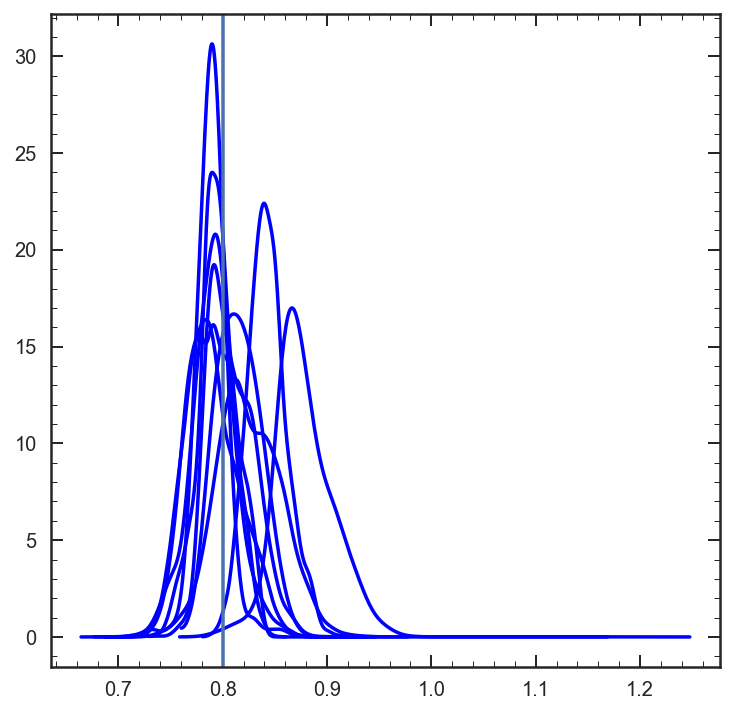

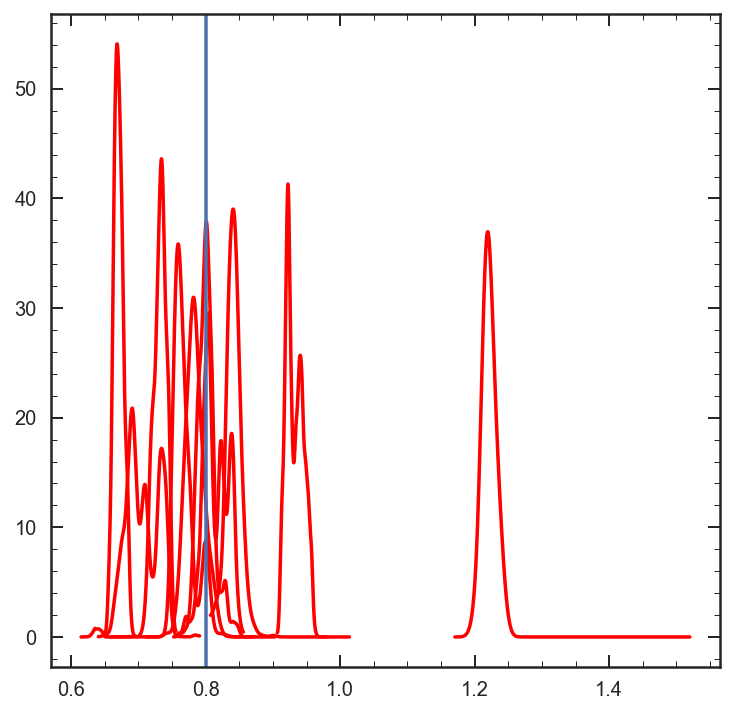

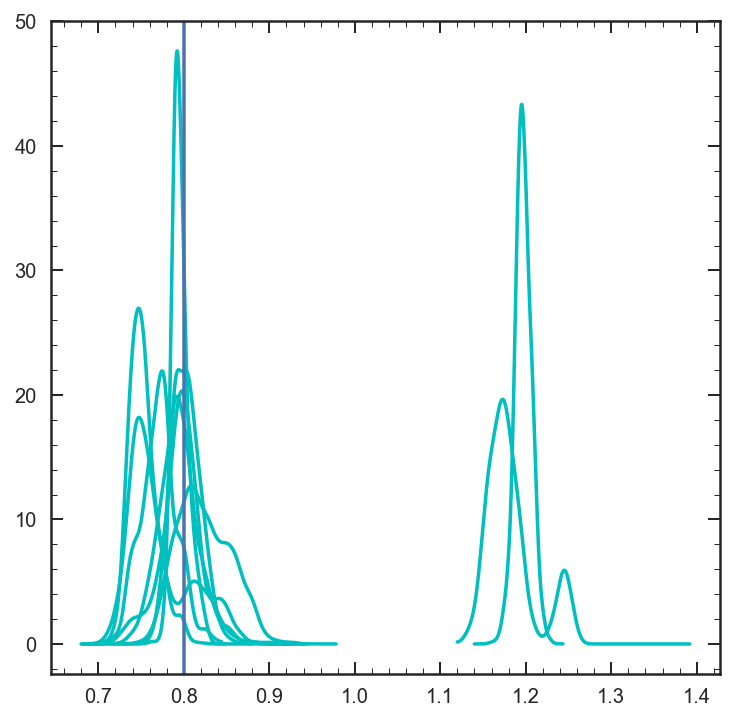

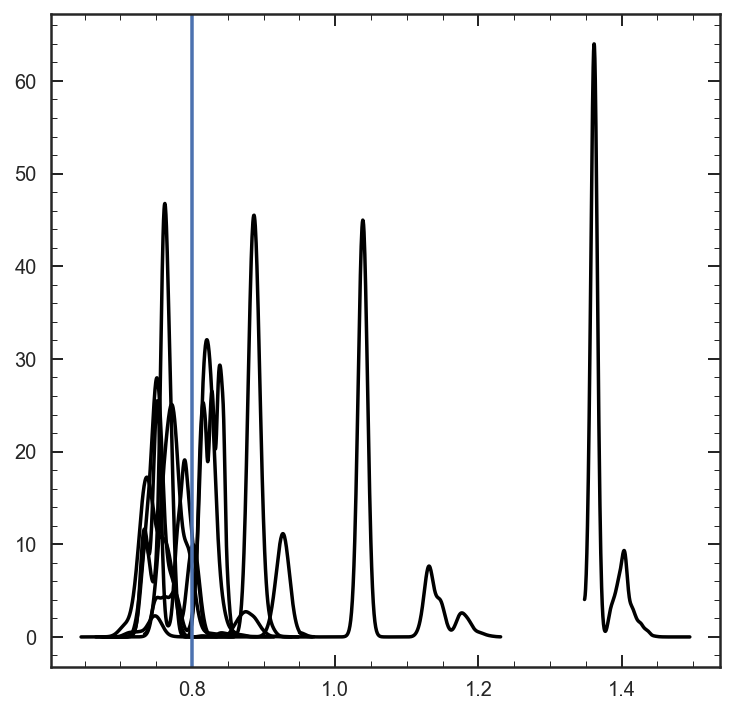

In [143]:
plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_multi_{0}.npy'.format(i+1)).item()
    m,Pm = Get_posterior(dres.samples[:,0], dres.logwt, dres.logz)
    
    plt.plot(m,Pm,'b')
plt.axvline(0.8)
    
plt.figure(figsize=[6,6])    
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_balls_{0}.npy'.format(i+1)).item()
    b,Pb = Get_posterior(dres.samples[:,0], dres.logwt, dres.logz)
    
    plt.plot(b,Pb,'r')

plt.axvline(0.8)

plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_single_{0}.npy'.format(i+1)).item()
    s,Ps = Get_posterior(dres.samples[:,0], dres.logwt, dres.logz)

    plt.plot(s,Ps,'c')
plt.axvline(0.8)

plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_cubes_{0}.npy'.format(i+1)).item()
    c,Pc = Get_posterior(dres.samples[:,0], dres.logwt, dres.logz)
    
    plt.plot(c,Pc,'k')
plt.axvline(0.8)

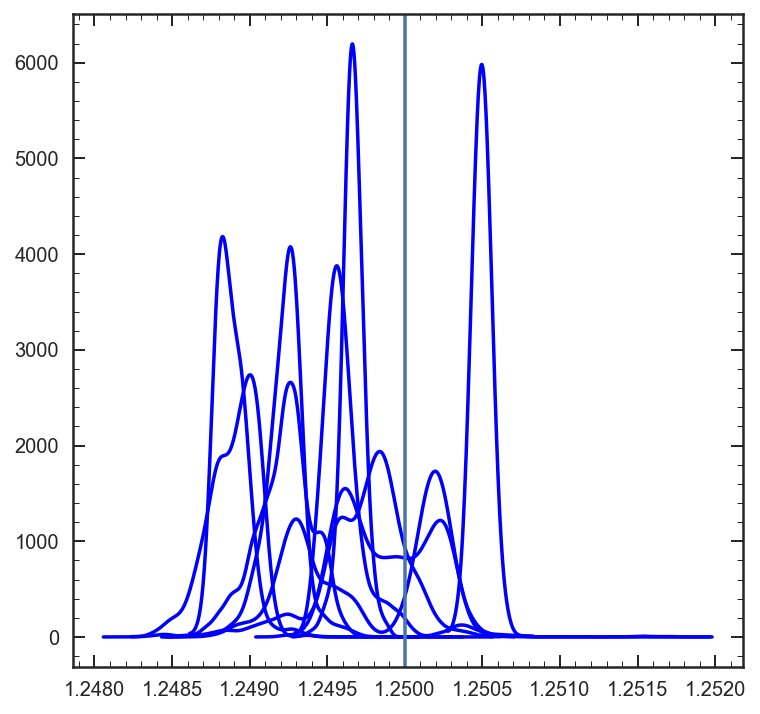

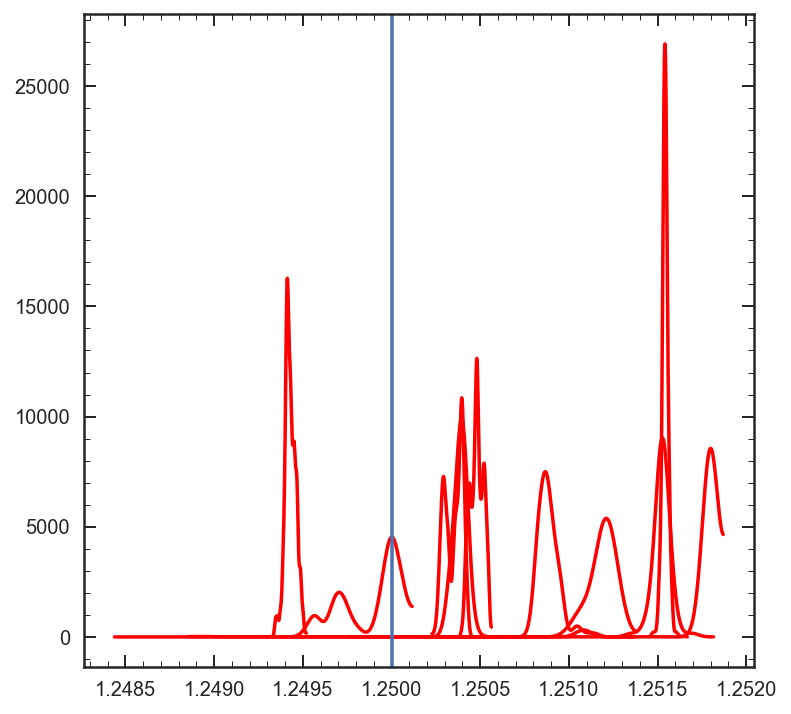

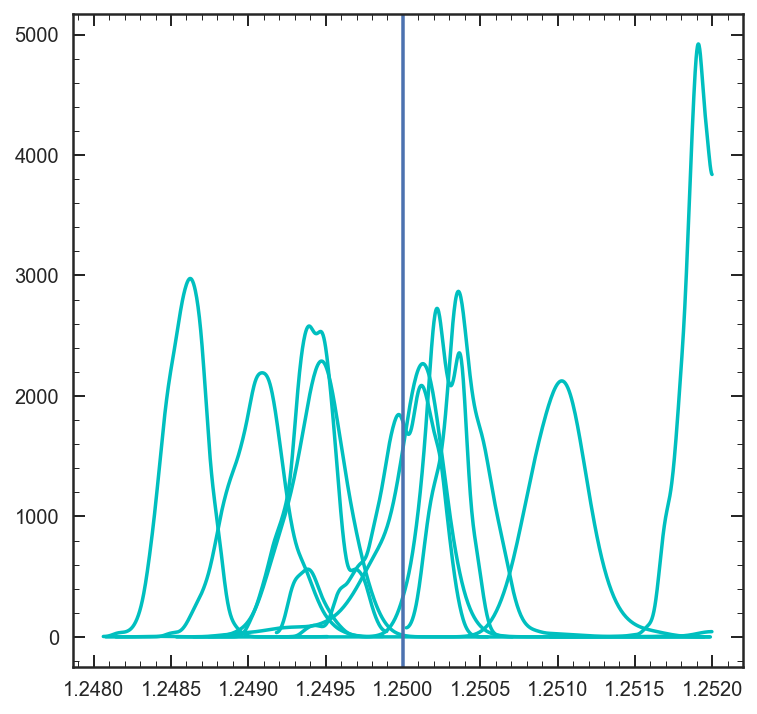

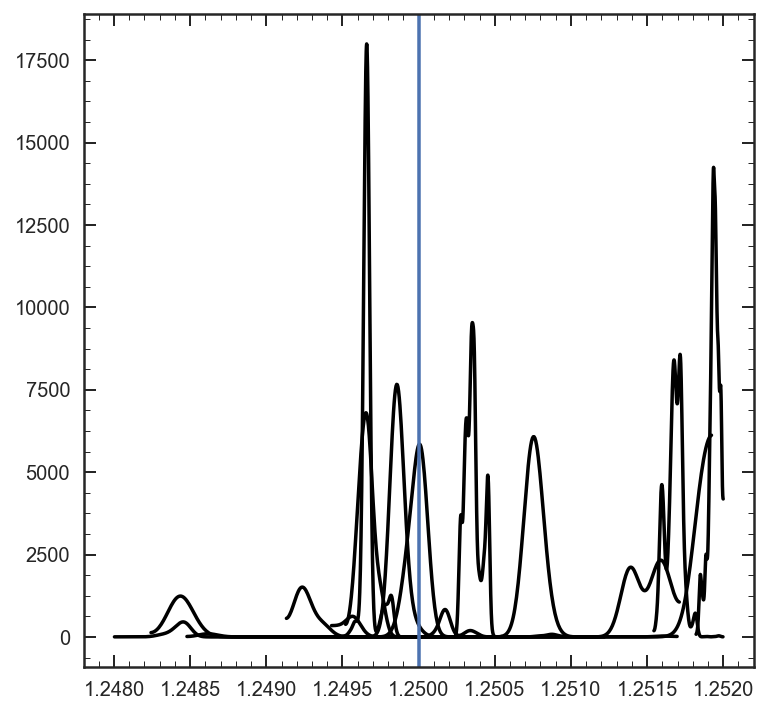

In [144]:
plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_multi_{0}.npy'.format(i+1)).item()
    m,Pm = Get_posterior(dres.samples[:,12], dres.logwt, dres.logz)
    
    plt.plot(m,Pm,'b')
plt.axvline(1.25)
    
plt.figure(figsize=[6,6])    
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_balls_{0}.npy'.format(i+1)).item()
    b,Pb = Get_posterior(dres.samples[:,12], dres.logwt, dres.logz)
    
    plt.plot(b,Pb,'r')

plt.axvline(1.25)

plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_single_{0}.npy'.format(i+1)).item()
    s,Ps = Get_posterior(dres.samples[:,12], dres.logwt, dres.logz)

    plt.plot(s,Ps,'c')
plt.axvline(1.25)

plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_cubes_{0}.npy'.format(i+1)).item()
    c,Pc = Get_posterior(dres.samples[:,12], dres.logwt, dres.logz)
    
    plt.plot(c,Pc,'k')
plt.axvline(1.25)


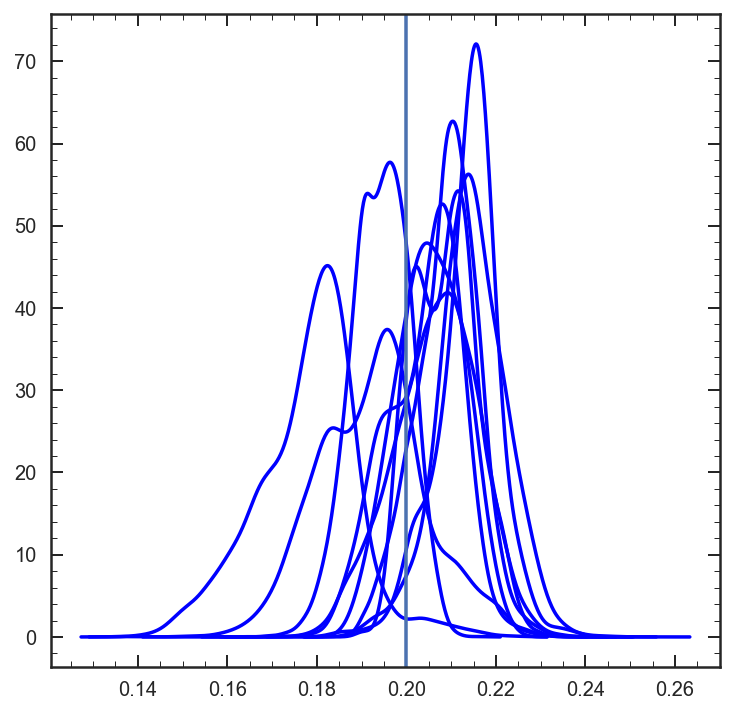

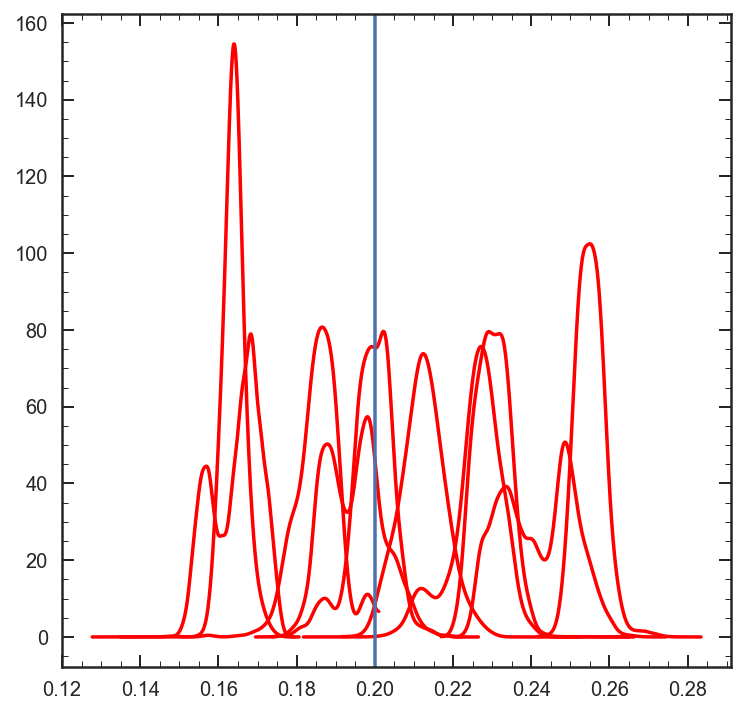

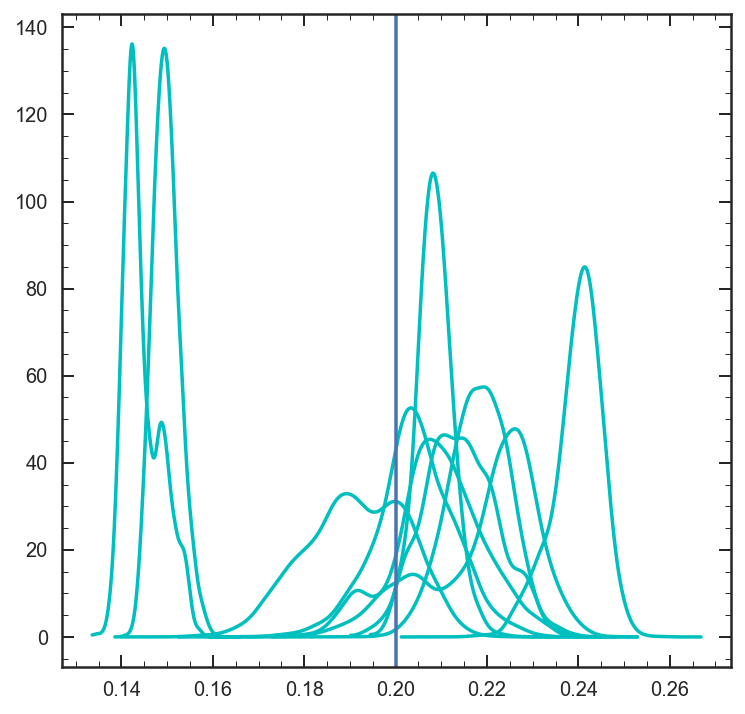

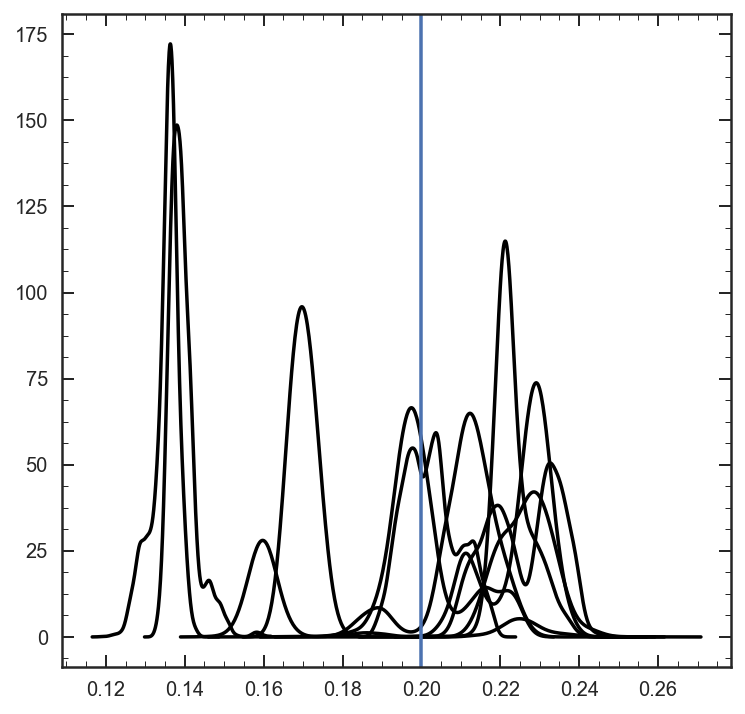

In [145]:
plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_multi_{0}.npy'.format(i+1)).item()
    m,Pm = Get_posterior(dres.samples[:,13], dres.logwt, dres.logz)
    
    plt.plot(m,Pm,'b')
plt.axvline(0.2)
    
plt.figure(figsize=[6,6])    
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_balls_{0}.npy'.format(i+1)).item()
    b,Pb = Get_posterior(dres.samples[:,13], dres.logwt, dres.logz)
    
    plt.plot(b,Pb,'r')

plt.axvline(0.2)

plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_single_{0}.npy'.format(i+1)).item()
    s,Ps = Get_posterior(dres.samples[:,13], dres.logwt, dres.logz)

    plt.plot(s,Ps,'c')
plt.axvline(0.2)

plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_cubes_{0}.npy'.format(i+1)).item()
    c,Pc = Get_posterior(dres.samples[:,13], dres.logwt, dres.logz)
    
    plt.plot(c,Pc,'k')
plt.axvline(0.2)


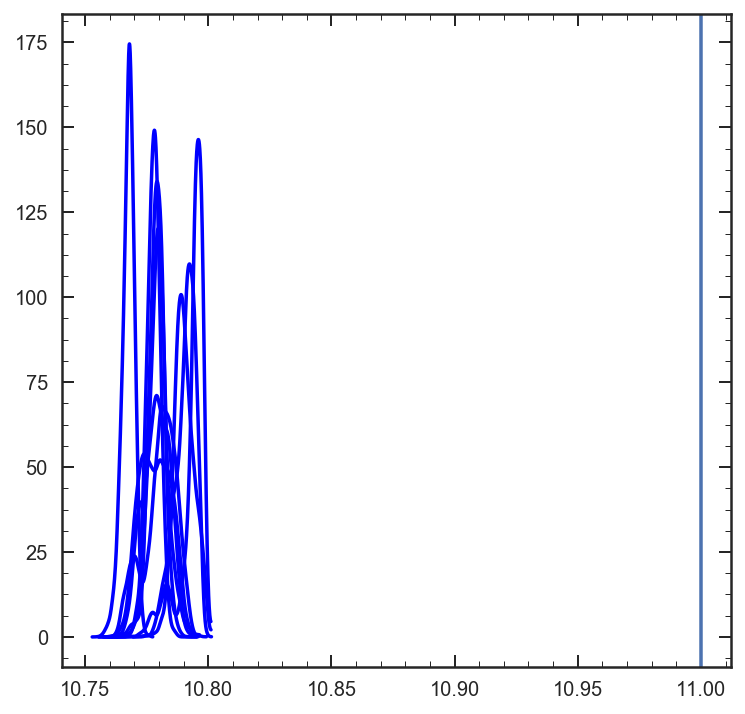

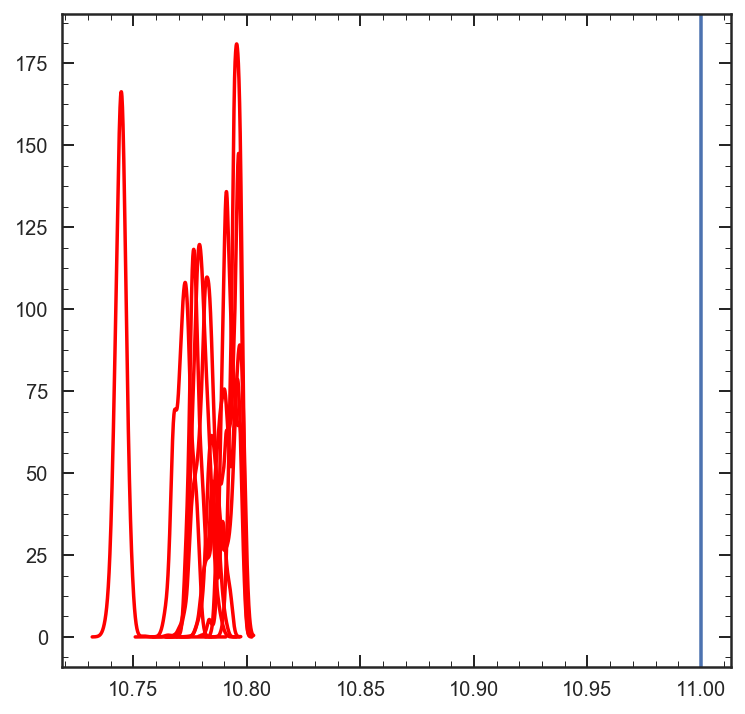

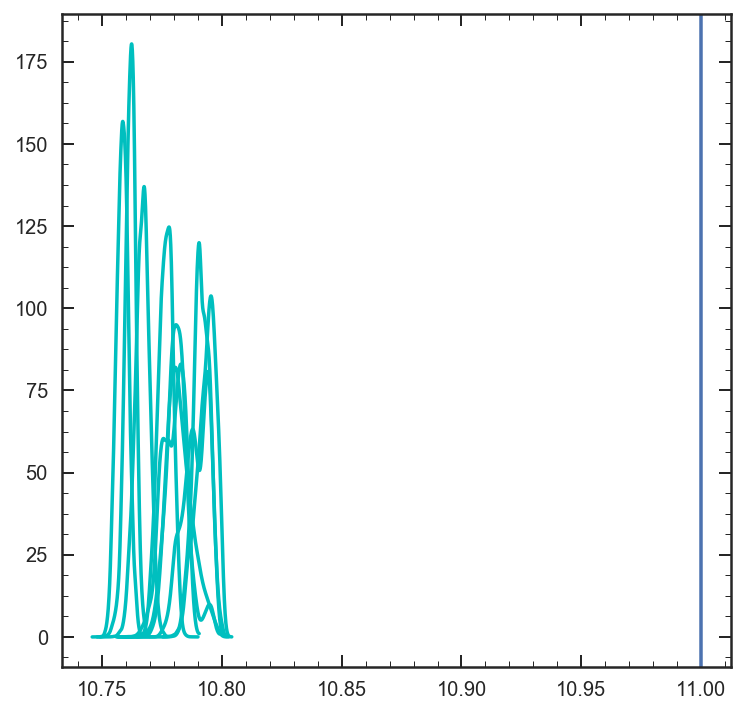

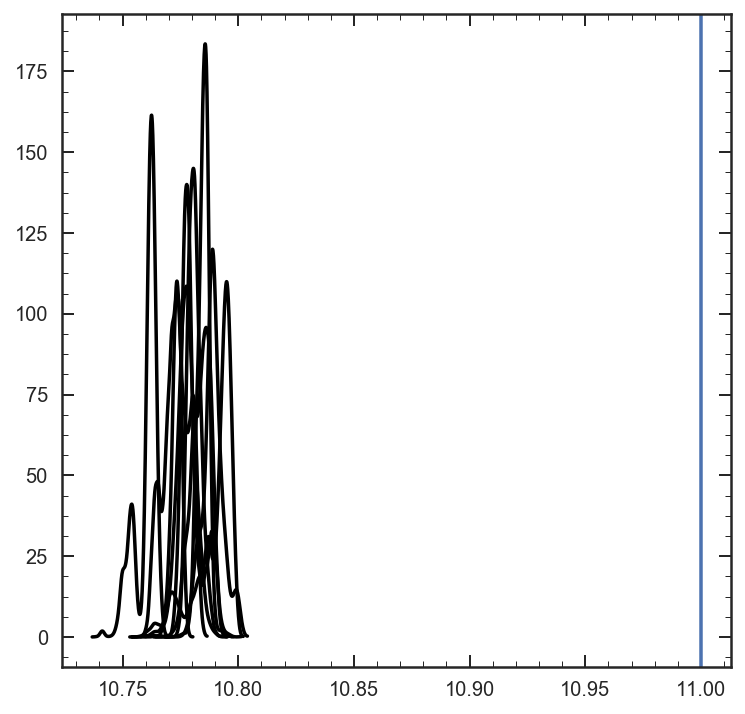

In [146]:
plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_multi_{0}.npy'.format(i+1)).item()
    m,Pm = Get_posterior(dres.samples[:,14], dres.logwt, dres.logz)
    
    plt.plot(m,Pm,'b')
plt.axvline(11)
    
plt.figure(figsize=[6,6])    
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_balls_{0}.npy'.format(i+1)).item()
    b,Pb = Get_posterior(dres.samples[:,14], dres.logwt, dres.logz)
    
    plt.plot(b,Pb,'r')

plt.axvline(11)

plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_single_{0}.npy'.format(i+1)).item()
    s,Ps = Get_posterior(dres.samples[:,14], dres.logwt, dres.logz)

    plt.plot(s,Ps,'c')
plt.axvline(11)

plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_cubes_{0}.npy'.format(i+1)).item()
    c,Pc = Get_posterior(dres.samples[:,14], dres.logwt, dres.logz)
    
    plt.plot(c,Pc,'k')
plt.axvline(11)